# Predicting the Presence of Various Objects in Greek Pottery Scenes

### Authors
- Kevin Mao
- Matthew Pauly
- Siona Prasad
- Eshika Saxena

## I. Introduction

### About This Notebook
   
   This notebook contains a data processing segment, where we extract the images and labels from the greek pottery image dataset. We follow with exploratory data analysis, where we conduct PCA analyses and explore class imbalances. The project then encompasses four main models, a baseline model, a downsampled model, augmented data model and a transfer learning model where we attempt to predict the presence of 10 different attributes in the greek pottery images. We end the notebook with visualization and discussion of our results and the limitations of this study.

### Motivation

Classification of greek pottery based on the scenes depicted on the vases is a difficult task and a signficant challenge in the field. Often, the image descriptions contain the only verbal information available on the vases, but these descriptions are not written with consistent language making the classification task very difficult. The goal of this project is to use machine learning to identify objects present in greek pottery scenes with the ultimate goal of creating an easier and more efficient classification system for the vases. 

### Summary

In this notebook, we process and explore the data and develop 4 distinct models aimed at identifying objects in greek pottery scenes.  Overall, we find that we are able to make significant progress in this classification problem using transfer learning methods. We faced challenges related to image quality and class imbalances that require further work, but we show a proof of concept that transfer learning and data augmentation tools can be very useful for identification of common objects in greek pottery image data.

## II. Imported Libraries and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import time
import json

from urllib.request import urlopen
from PIL import Image, ImageOps

from tqdm.auto import tqdm, trange

import os
import pathlib
import time
import zipfile

import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout 
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import random
import pandas as pd

%matplotlib inline

print(f"Using TensorFlow version: {tf.__version__}")
print(f"Using TensorFlow Datasets version: {tfds.__version__}")
print(f"Using TensorFlow AddOns version: {tfa.__version__}")

Using TensorFlow version: 2.4.1
Using TensorFlow Datasets version: 4.2.0
Using TensorFlow AddOns version: 0.12.1


In [2]:
run_download = False

def safe_request(link):
        r = requests.get(link)
    #     time.sleep(2)
        return r

if run_download:
    webpages = []
    for page in trange(1,1158):
        link = f"http://armsandarmor.orphe.us/api/items/?format=json&page={page}"
        r = safe_request(link)
        webpage = json.loads(r.text)
        webpages.append(webpage)

    # join results of all pages
    all_pages = []
    for page in webpages:
        all_pages.extend(page['results'])
        
    # convert data to df
    all_files = []
    for i in range(len(all_pages)):
        # extract metadata for vase i
        result = all_pages[i]
        id = result['id']
        data_dict = {'id': id}
        for item in result['metadata']:
            data_dict[item['label']] = item['value']

        # extract image urls for vase i
        # each vase can have multiple images
        for file in result['files']:
            this_file_data = data_dict.copy()
            this_file_data['image'] = file['filepath']
            all_files.append(this_file_data)
    df = pd.DataFrame(all_files)  # page 1's DataFrame
    df.to_csv("data.csv")   
    
else:
    df = pd.read_csv("data.csv")
df.head()

/usr/share/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (14,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,id,Source ID,Vase Number,Fabric,Technique,Shape Name,Date,Attributed To,Decoration,Publication Record,Pleiades URI,Color,Provenance,LIMC ID,LIMC Web,CAVI Collection,image,Transcription,TranscriptionTrimmed
0,0,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/mQxPdwYS...,NaN,NaN
1,1,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/PUxm6FWQ...,NaN,NaN
2,2,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/WzgM2ybZ...,NaN,NaN
3,3,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/ooPvVYEv...,NaN,NaN
4,4,9338,{7BE358FB-23CE-402F-8D89-51D738C48C5D},1.0,ATHENIAN,BLACK-FIGURE,"AMPHORA, NECK",-550 to -500,CHIUSI P by KUNZE-GOTTE,"A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEM...","Corpus Vasorum Antiquorum: MUNICH, MUSEUM ANTI...",https://pleiades.stoa.org/places/413393,Grey,"ITALY, ETRURIA, VULCI",6368,http://ark.dasch.swiss/ark:/72163/080e-73fdcff...,-,https://iiif-orpheus.s3.amazonaws.com/3Lof9mrm...,NaN,NaN


The dataframe depicts the raw data that contains links to the images in the Pleiades URI column and the image descriptions in the Decoration column.

## III. Data Preprocessing

Images of Ancient Greek vases were pulled from the https://armsandarmor.orphe.us/ website API, which had over 100,000 images of Ancient Greek vases, along with associated datapoints for each image such as fabric, vase shape name, technique (red figure vs. black figure), decoration, and color. Many of these images were also labelled with descriptions from researchers, though these descriptive tags were not standardized across images (no shared vocabulary) and not all images had an associated description.

Many, but not all, of the items in the dataset contain a short description written by a human. While the descriptions are not always consistent, they provide some of the only labeled data we have to work with. From the captions we were able to extract features that we then treated as our y labels. Some example descriptions are displayed below:

In [3]:
print(df['Decoration'].values[[0, 6, 1000, 2000, 10000, 45000]])

['A,B: TRIPTOLEMOS ON WINGED CHARIOT BETWEEN DEMETER AND PERSEPHONE'
 'B: WARRIOR AND CHARIOTEER IN CHARIOT (TURNING), BOTH WITH BOEOTIAN SHIELDS'
 'Neck A2: WOMEN (CARRYING POMEGRANATE, WREATH, LOTUS FLOWER)'
 'A: AMAZONOMACHY, HERAKLES AND AMAZONS, BOEOTIAN SHIELD' 'B: KOMOS'
 'A: FIGHT, HEKTOR AND ACHILLES FIGHTING OVER RAM, PHOINIX AND PRIAM, HELMET AND SWORD SUSPENDED (ALL NAMED, PHOINICHS), SHIELD DEVICE, LION']


We identified frequent attributes found in these descriptions such as 'chariot' or 'shield'. The presence or absence of each of these attributes was treated as a binary feature. After surveying a large number of images and descriptions, the 10 most frequent attributes that were present were: 'CHARIOT', 'SPEAR', 'WARRIOR', 'SHIELD', 'WREATH', 'CAULDRON', 'PLANT', 'DISCS', 'ANCHOR', 'CLUB'. In this project, we attempt to do multiclass predictions on the presence of these 10 attributes.

We used a 128x128 resolution to ensure that the finer details of images could be detected by the model. In addition, we note that this is a black-figure model. We use only black-figure images in this project, as black-figure vases have more visually-distinct edges that could make predictive modeling easier.

In [4]:
data_processed = True

if not data_processed:
    # narrow dataframe to only black-figure images
    idxs = df['Technique'].isin(['BLACK-FIGURE'])
    df = df[idxs].reset_index(drop=True)

    # manually chosen set of attributes to predict
    atts = ['CHARIOT', 'SPEAR', 'WARRIOR', 'SHIELD', 'WREATH', 'CAULDRON', 'PLANT', 'DISCS', 'ANCHOR', 'CLUB']
    # create binary indicator variables per attribute
    for ind, att in enumerate(atts):
        df[att] = np.where((df.Decoration.str.contains(att,case=False)),1,0)

    # combine all the binary indicators into a single list
    df['combined'] = df[atts].values.tolist()
    df.dropna(subset = ["Decoration"], inplace=True)
    df = df.reset_index(drop=True)
    
    # access images
    raw_images = []
    new_df = df.copy()
    for i,url in enumerate(tqdm(df['image'])):
        try:
            img = Image.open(urlopen(url))
    #         time.sleep(2)  # safe requests!
            raw_images.append(img)
        except:
            print(f"Error with image {i}, removing from dataset.")
            new_df = new_df.drop(i)
    print("\n")
    new_df = new_df.reset_index(drop=True)
    plt.imshow(raw_images[0])
    del df
    
    # transform to grayscale and resize to 128x128 (dimension needed for transfer learning)
    images = []
    for ind, img in enumerate(raw_images):
        new = img.resize((128,128))
        new = ImageOps.grayscale(new)   # grayscale
        new = np.array(new)/255.        # pixel values between 0 and 1
        raw_images[ind] = new
    
    # correct dimensions
    raw_images = np.array(raw_images).reshape(-1,128,128,1)
    y = np.array((new_df['combined'])).reshape(-1,1)
    
    # split into train and test sets (while keeping multiple copies of single images in same split)
    vase_nums = new_df['Vase Number'].unique()
    train_vases = np.random.choice(vase_nums, size=int(0.7*len(vase_nums)), replace=False)
    test_vases = [num for num in vase_nums if num not in train_vases]

    y_train = y[new_df['Vase Number'].isin(train_vases)]
    y_test = y[new_df['Vase Number'].isin(test_vases)]

    np.save('X_train', raw_images[new_df['Vase Number'].isin(train_vases)])
    np.save('y_train', y_train)
    np.save('X_test', raw_images[new_df['Vase Number'].isin(test_vases)])
    np.save('y_test', y_test)
    
del df

# Load datasets
X_train = np.load('X_train.npy', mmap_mode='r')
X_test = np.load('X_test.npy')
y_train_temp = np.load('y_train.npy', allow_pickle=True)
y_test_temp = np.load('y_test.npy', allow_pickle=True)
y_train = np.array([np.array(y_train_temp[i][0]) for i in range(len(y_train_temp))])
y_test = np.array([np.array(y_test_temp[i][0]) for i in range(len(y_test_temp))])

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (28039, 128, 128, 1)
X_test shape: (12387, 128, 128, 1)
y_train shape: (28039, 10)
y_test shape: (12387, 10)


Training on the dataset images would involve normalization of the images. Two methods for resizing the images included directly resizing the image (which would distort image ratios) or cropping the image to the desired image ratio before resizing the image. Cropping intuitively would be a good idea for image normalization, as images of objects such as spears and chariots depend heavily on aspect ratios, which would be affected by direct resizing. However, because it is difficult to find the best areas to crop, we may be cutting out essential image features by cropping. We decided to resize the image to a size of 128 by 128 (we would not be accidentally cutting portions out). This specific dimension was chosen because it is compatible with transfer learning and still maintains a balance of resolution and computing/memory resource usage.

### Literature Review

We conducted a brief literature review to assess what work has been done in the field already. Bishop et al. have developed a Greek Pottery Shape and School Identification and Classification System [1]. They used computer vision techniques to segment the vase from the background, and then extract features such as the area, bounding box, major/minor axis length, eccentricity, etc. These properties were then compared to the rest of the database to identify the five closes matching pieces. The system was able to detect shapes with a 99 percent accuracy rate and detect color convention (red-figure vs black-figure) with a 98 percent accuracy rate. These results are promising and suggest that the pottery images do contain enough information to identify automatically the shape and color. The feature extraction techniques they use could also be helpful to keep in mind when training a classification model in the case that the model does not automatically learn to identify these distinguishing features.

Gualandi et al. developed a novel deep-learning architecture for appearance-based recognition of pottery images in the field [2]. For this task of classifying pottery based on colors, patterns, etc., a transfer learning approach with the ResNet50 model trained on ImageNet was used. Data augmentation (varied luminosity, contrast, and flipping) was also implemented to increase the training set size. Finally, a novel weighting technique that considers the error of ground truths and false positives was used in the loss to combat class imbalance and heterogeneity in the data. These strategies significantly improved model performance, which achieved 83.8 percent accuracy at its best. We plan to adopt some of these strategies when training our classification model to improve its performance.

[1]  G. Bishop, S. Cha, and C. Tappert.  A greek pottery shape and school identification and classificationsystem using image retrieval techniques.  2005.

[2]  Maria Letizia Gualandi, Gabriele Gattiglia, and Francesca Anichini.  An open system for collection andautomatic recognition of pottery through neural network algorithms.Heritage, 4(1):140–159, 2021.

## IV. Exploratory Data Analysis

### Example Images

We started our exploratory data analysis by viewing examples of images that contain different attributes. We see that certain attributes are more clearly visible such as the chariot in the first photo. Other attributes are more difficult to distinguish due to the curvature of the pottery and general quality/coloration of the images. 

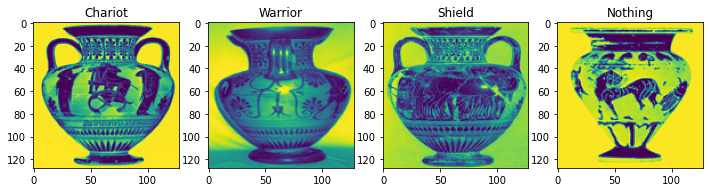

In [5]:
## Display some examples of pottery with various attributes
images = [1,150,308,300]
labels = ['Chariot', 'Warrior','Shield','Nothing']
fig, ax = plt.subplots(1, 4, figsize=(12, 24))

for i in range(4):
    ax[i].imshow(X_train[images[i]])
    ax[i].set_title(labels[i])

### Principle Component Analysis

In order to understand if the overall characteristics of the pixels conveyed information on different attribute presences (chariots, spears etc), we conducted a PCA analysis and looked for any natural clustering in the data. The image data was first flattened, in order to make PCA possible. We recognize that image flattening removes crucial information on the spacial relationships of pixels, and that 2 component PCA likely does not capture enough information given a 128 by 128 image. We used PCA as a starting point for EDA considering that it is still able to capture big-picture characteristics of the data.

PCA1 Variance Explained 0.2575
PCA2 Variance Explained 0.1178


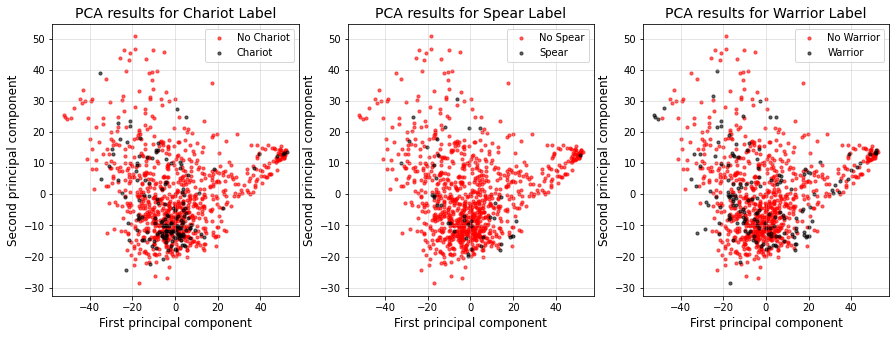

In [6]:
from sklearn.decomposition import PCA

X_train_pca = X_train.reshape(-1,16384)[0:1000, :]
y_train_pca1 = y_train.reshape(-1,10)[0:1000, 0]
y_train_pca2 = y_train.reshape(-1,10)[0:1000, 1]
y_train_pca3 = y_train.reshape(-1,10)[0:1000, 2]

pca = PCA(n_components=2).fit(X_train_pca)
print('PCA1 Variance Explained', round(pca.explained_variance_ratio_[0], 4))
print('PCA2 Variance Explained', round(pca.explained_variance_ratio_[1], 4))
pca_res = pca.transform(X_train_pca)

group1 = y_train_pca1.reshape(-1,1)
group2 = y_train_pca2.reshape(-1,1)
group3 = y_train_pca3.reshape(-1,1)

cdict = {0: 'red', 1: 'black'}
fig, ax = plt.subplots(1,3, figsize = (15,5))
res_x = pca_res[:,0].reshape(-1,1)
res_y = pca_res[:,1].reshape(-1,1)
labels1 = ['No Chariot', 'Chariot']
labels2 = ['No Spear', 'Spear']
labels3 = ['No Warrior', 'Warrior']

for g in np.unique(group1):
    ix = np.where(group1 == g)
    ax[0].scatter(res_x[ix], res_y[ix], c = cdict[g], label = labels1[g],s=10, alpha=0.6)
    ax[0].grid(":", alpha=0.4)
    
for g in np.unique(group2):
    ix = np.where(group2 == g)
    ax[1].scatter(res_x[ix], res_y[ix], c = cdict[g], label = labels2[g],s=10, alpha=0.6)
    ax[1].grid(":", alpha=0.4)
    
for g in np.unique(group3):
    ix = np.where(group3 == g)
    ax[2].scatter(res_x[ix], res_y[ix], c = cdict[g], label = labels3[g],s=10, alpha=0.6)
    ax[2].grid(":", alpha=0.4)

ax[0].set_xlabel("First principal component", fontsize=12)
ax[0].set_ylabel("Second principal component", fontsize=12)
ax[0].set_title("PCA results for Chariot Label", fontsize=14)
ax[0].legend()

ax[1].set_xlabel("First principal component", fontsize=12)
ax[1].set_ylabel("Second principal component", fontsize=12)
ax[1].set_title("PCA results for Spear Label", fontsize=14)
ax[1].legend()

ax[2].set_xlabel("First principal component", fontsize=12)
ax[2].set_ylabel("Second principal component", fontsize=12)
ax[2].set_title("PCA results for Warrior Label", fontsize=14)
ax[2].legend()

plt.show()

The variance explained by the top two components is 37\%. The figures above  shows the top 2 PCA components with the left image coded by chariot presence, middle image coded by spear presences and the right image coded by warrior presence. We did not expect to see good separation in any of these PCA plots because the presence of these attributes do not corresponds to value changes across all pixels (which is the only information really captured by a flattened image). There are no clear boundary seen. This also may be due to the fact that only 37\% of variance is captured by the PCA plot -- better separation may be seen in higher dimensions.

### Class Imbalances

To better understand the distribution of labels for each attribute in our training set, we computed and plotted the frequency of the positive and negative instances of each attribute. 

In [7]:
def class_imbalance_df(y_train):
    df = pd.DataFrame(y_train)
    df.columns = ['CHARIOT', 'SPEAR', 'WARRIOR', 'SHIELD', 'WREATHS', 'CAULDRON', 'PLANTS', 'DISCS', 'ANCHOR', 'CLUB']
    new_df = pd.DataFrame()
    # compute value_counts for each column
    for col in df.columns:
        new_df[col] = df.value_counts(df[col])
        
    # combine in a new dataframe
    new_df = new_df.reset_index(drop=True)
    return new_df

In [8]:
print("Frequency of Each Label in Training Set")
count_df = class_imbalance_df(y_train)
display(count_df)

Frequency of Each Label in Training Set


,CHARIOT,SPEAR,WARRIOR,SHIELD,WREATHS,CAULDRON,PLANTS,DISCS,ANCHOR,CLUB
0,24835,26558,23550,25337,27414,28018,27940,27219,28015,27598
1,3204,1481,4489,2702,625,21,99,820,24,441


In [9]:
def plot_classes(count_df):
    fig, ax = plt.subplots(5, 2, figsize = (15,12))
    ax_new = count_df.plot.bar(rot=0, subplots=True, ax=ax)
    for i in range(10):
        ax_new[i].set_xlabel("Value")
        ax_new[i].set_ylabel("Frequency") 
        ax_new[i].set_title(f"Label Frequencies for {count_df.columns[i]}")

    plt.tight_layout()

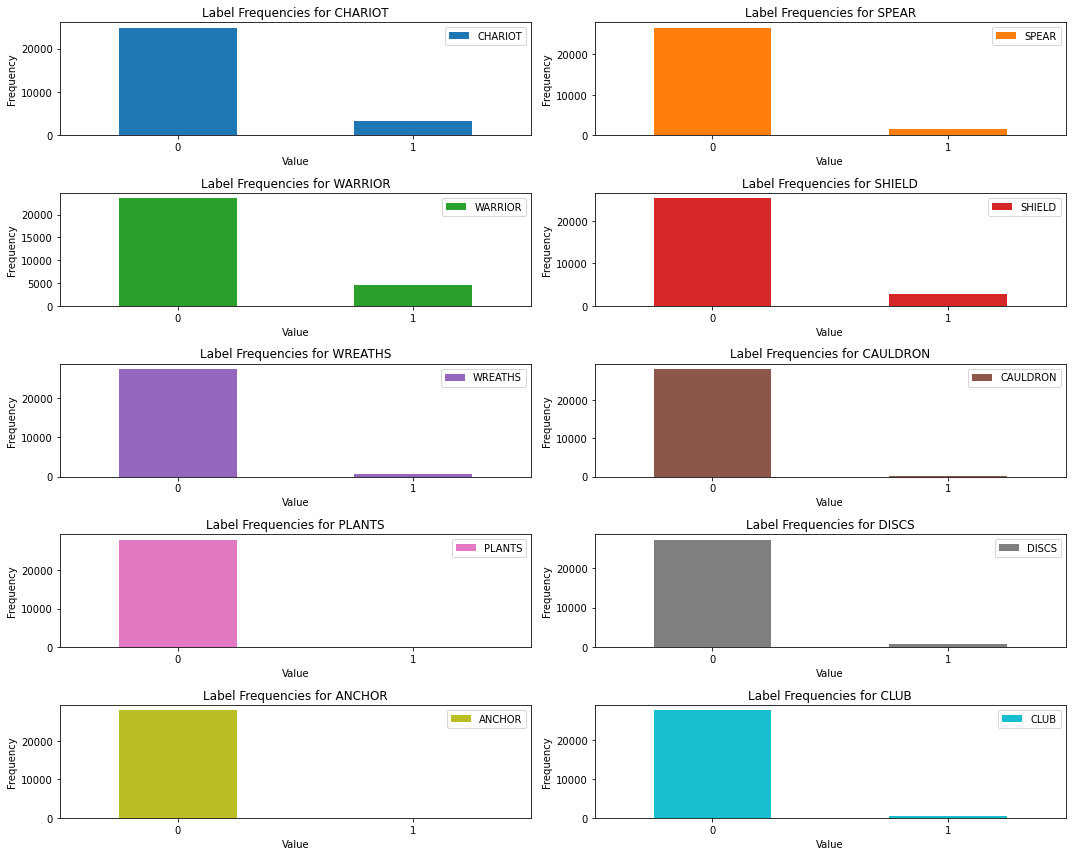

In [10]:
plot_classes(count_df)

**FINDINGS:** 

In plotting the number of examples with label 0 and label 1 for each of the chosen 10 categories, we found that there was a major class imbalance in this dataset. For some of the categories, there were 1000 times more examples labeled 0 compared to exampled labeled 1. We anticipate that this extreme class imbalance will make training the model difficult, especially for categories where there are less than 100 positive examples. This is because even a naive model that predicts 0 for all cases would have an extremely high accuracy, but our goal is to train the model to distinguish between the 0 and 1 classes for all categories. For this reason, we will use metrics like precision, recall, and F1 in addition to accuracy to assess our model performance. 

To address the problem of class imbalance, there are multiple approaches we can take. We will try downsampling from the majority class (randomly select n examples from the majority class if the minority class has n examples), and data augmentation (create synthetic data examples to increase the size of the minority class).

## V. Research Question

For this project, we plan to focus on the classification task of classifying vase images based on the content of the scene, as determined from the captions provided in the dataset. 

Our primary goal will be to extract labels from the captions and then use those labels for image classification. For example, we will first determine which items are present in an image and create a label vector based on that information (e.g [0,1,0] corresponds to labels [sword, shield, spear] when only a shield is present). We will then feed the images and these corresponding labels to train a classification model that can identify those labels just from the images.

We propose the following approaches:
- Extracting image labels from captions and training a multi-class classification CNN for determining which basic items are present in an image 
- Using transfer learning (VGG trained on ImageNet) for feature extraction and retraining the last layer and/or using a separate classification model to identify the vase classes.


## VI. Baseline Model

### Model Architecture

We opted to based our model architecture on the SOTA VGG16 model, as this model is known to perform well in image classification tasks. One difficulty is that the VGG16 model is generally used to predict on mutually exclusive classes, such as identifying whether an image is of a dog or cat. However, in our model, we aim to identify whether certain objects are in the picture, which is not mutually exclusive. For example, both a chariot and a spear could appear in the same vase painting.

To accomodate this difference, we made a few changes from the VGG16 model. Most notably, we changed the last layer to be made of a Dense(10) layer with sigmoid activations. We used 10 nodes, as there were 10 objects that we were predicting on. In addition, we use sigmoid because we want to classify whether or not a certain object $i$ is present within the image. Thus, we could interpret the output from Dense node $i$ as the probability that its corresponding object is in the image.

### Metrics Functions

In [11]:
# get per class f1 score and accuracy
def get_metrics(model, X, y, class_names=None):
    y_pred = model.predict(X).round().astype(int)
    
    data = {}
    if class_names:
        data['class'] = []
    data['accuracy'] = []
    data['precision'] = []
    data['recall'] = []
    data['f1 score'] = []
    data['naive accuracy'] = []
    data['data positives'] = []
    data['predicted positives'] = []    
    
    for i in range(y.shape[1]):
        if class_names:
            data['class'].append(class_names[i])
        
        data['accuracy'].append((y[:,i] == y_pred[:,i]).mean())
        data['precision'].append(precision_score(y[:,i], y_pred[:,i]))
        data['recall'].append(recall_score(y[:,i], y_pred[:,i]))
        data['f1 score'].append(f1_score(y[:,i], y_pred[:,i]))
        data['naive accuracy'].append((y[:,i] == 0).mean())
        data['data positives'].append(y[:,i].sum())
        data['predicted positives'].append(y_pred[:,i].sum())

        print(f"Confusion Matrix for {class_names[i]}")
        print(confusion_matrix(y[:,i], y_pred[:,i]))
        
    return pd.DataFrame(data)

In [12]:
def plot_acc_loss(history_dict):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # plot loss
    ax[0].plot(history_dict['loss'], 'r', label='Training Loss')
    ax[0].plot(history_dict['val_loss'], 'b', label='Validation Loss')
    ax[0].legend()
    ax[0].set_title('Epochs vs. Loss for Train and Validation Data')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')

    # plot accuracy
    ax[1].plot(history_dict['binary_accuracy'], 'r', label='Training Accuracy')
    ax[1].plot(history_dict['val_binary_accuracy'], 'b', label='Validation Accuracy')
    ax[1].legend()
    ax[1].set_title('Epochs vs. Accuracy for Train and Validation Data')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')

    plt.tight_layout()

In [13]:
# generate visualizations
#  code from pset 4
def vizualize(model, X, y, class_index=0):
    # get true and false, positive and negative
    y_pred = model.predict(X).round().astype(int)
    
    # get true positives
    tps = []
    for i in range(len(X)):
        if y[i, class_index] == 1 and y_pred[i, class_index] == 1:
            tps.append(X[i])
    # get false positives
    fps = []
    for i in range(len(X)):
        if y[i, class_index] == 0 and y_pred[i, class_index] == 1:
            fps.append(X[i])
    # get true negatives
    tns = []
    for i in range(len(X)):
        if y[i, class_index] == 0 and y_pred[i, class_index] == 0:
            tns.append(X[i])
    # get false negatives
    fns = []
    for i in range(len(X)):
        if y[i, class_index] == 1 and y_pred[i, class_index] == 0:
            fns.append(X[i])
    
    assert len(tps) > 0 and len(fps) > 0 and len(tns) > 0 and len(fns) > 0
    
    # choose random examples
    images = [
        random.choice(tps),
        random.choice(fps),
        random.choice(tns),
        random.choice(fns)
    ]
    
    # get saliency maps
    saliency_images = []
    heatmap_images = []
    
    # setup functions for the saliency maps
    def loss(output):
        return (output[0][class_index])

    def model_modifier(m):
        m.layers[-1].activation = tf.keras.activations.linear
        return m
        
    for i in range(4):
        # get SmoothGrad saliency map
        saliency = Saliency(model_transfer, model_modifier=model_modifier, clone=False)
        saliency_map = saliency(loss, images[i], smooth_samples=20, smooth_noise=0.2)
        saliency_map = normalize(saliency_map)
        saliency_images.append(saliency_map.reshape((128, 128)))
    
    # make plots
    fig, ax = plt.subplots(4, 2, figsize=(6, 12))
    
    titles = ['True Positive', 'False Positive', 'True Negative', 'False Negative']
    
    for i in range(4):
        ax[i, 0].imshow(images[i])
        ax[i, 0].set_title(titles[i])
        ax[i, 1].imshow(saliency_images[i])
        ax[i, 1].set_title('Saliency Map\nFor True Class')
        
    fig.tight_layout(pad=1.5)

In [14]:
# function for generating our desired architecture
# making this a function makes it far easier to generate
# empirical parameter counts, and to reuse the model architecture
# but with different parameters for both Part 1 and Part 2

def vgg_architecture(input_shape, n_output, conv_0_filters, dense_units,
                     conv_dropout=0.25, dense_dropout=0.5,
                     filter_shape=(3,3), pool_size=(2,2),
                     output_activation="softmax"):
    """generate simplified vgg-like sequential convolutional model
    
    This function can be used for building either a vgg-like
    classification model for PART 1 or regression model for PART 2
    depending on what is specified for the n_output and 
    output_activation parameters
    """
    n = conv_0_filters
    fs = filter_shape
    
    inputs = Input(shape=input_shape)
    x = Conv2D(
                n, fs, padding="same", activation="relu"
            )(inputs)
    x = Conv2D(n, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*2, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*2, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*4, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*4, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Flatten()(x)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dense_dropout)(x)
    
    y = Dense(n_output, activation="sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=y)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["binary_accuracy"])

    return model

### Model Architecture (Part 2)

Below the model summary, we've also printed the expected shapes for the input and output. The input is designed for a single image, so the input shape is (128, 128, 1). The output is a row of 10 values, each corresponding to an object we decided to investigate. Since we are using sigmoid activation, the value of each output at index $i$ can be interpreted as the probability the model assigns to the corresponding object $i$ being present in the image.

In [15]:
conv_0_filters = 32
n_output=10

vgg_model = vgg_architecture(
    input_shape=(128,128,1), n_output=n_output, conv_0_filters=conv_0_filters, 
    dense_units=1000, output_activation="sigmoid")
vgg_model.summary()

# print number of params in model I will be training
print(
    "\n\nThe VGG-like model we will be training "
    "has {} filters in the first convolutional layer and it contains "
    "a total of {:,} parameters.".format(
        conv_0_filters, vgg_model.count_params()
    )
)

print("Input", vgg_model.input_shape, "\nOutput", vgg_model.output_shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928 

In [16]:
%%time

# After training your model, set the use_saved_model variable
# to True, and this cell will simply reload your already saved
# model and training history
use_saved_model = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train model if use_saved_model=False, else load saved model
if use_saved_model:
    vgg_model.load_weights("model/baseline/vgg_model.ckpt")
    with open("model/bl_vgg_model_hist_dict.pickle", "rb") as filehandler:
        history_vgg_dict = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_vgg = vgg_model.fit(X_train, y_train,
                        epochs=100, validation_split=0.2,verbose=1, callbacks=[early_stopping])

    # extract history dict from model history object
    history_vgg_dict = history_vgg.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists('/content/drive/MyDrive/cs109b_final/model'):
        os.mkdir('/content/drive/MyDrive/cs109b_final/model')
    # save fitted training history dict using pickle
    with open("/content/drive/MyDrive/cs109b_final/model/vgg_model_hist_dict.pickle", "wb") as filehandler:
        pickle.dump(history_vgg_dict, filehandler)
    # save model weights for future use
    vgg_model.save_weights("/content/drive/MyDrive/cs109b_final/model/vgg_model/vgg_model.ckpt")
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Model weights and training history successfully loaded from previously trained model.

CPU times: user 84.7 ms, sys: 41.4 ms, total: 126 ms
Wall time: 126 ms


**Model Training**

We experimented with different hyperparameters in order to improve the F1 scores reported below. One of the key points in hyperparameter tuning was the number of epochs we allowed the model to run for. We settled on a relatively high number of epochs with early stopping. Though, in terms of binary accuracy, this resulting in some possible overfitting (as we can see the validation loss increasing over several epochs with the training loss decreasing), we found that sacrificing accuracy for F1 score was worthwhile for this model.

Keeping in mind the relative rarity of certain tags, this trade-off occurs as the trained model begins to move away from the naive model, where it no longer classifies the rare tags as always negative and makes an attempt to identify positive cases. Moving away from a naive model allows the F1 scores to increase, while the binary accuracy may begin to slightly decrease. With more positive examples of the rare tags available, we could potentially expect to see both an improve F1 score and a high binary accuracy, though this is not the case with the currently available dataset.

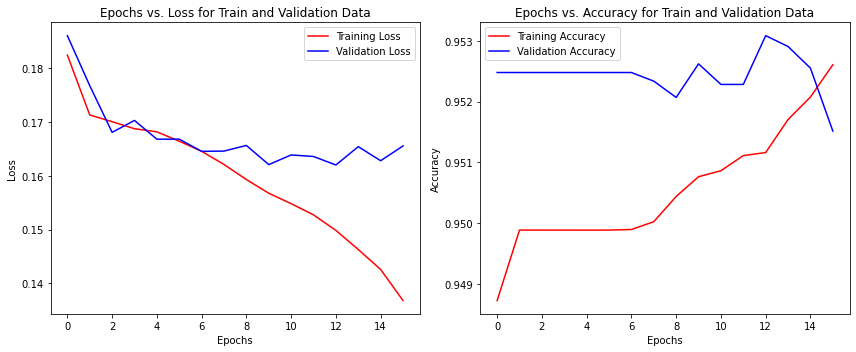

In [17]:
plot_acc_loss(history_vgg_dict)

### Final Results (Baseline Model)

Below displays the confusion matrices for each tag, as well as the corresponding accuracy, precision, recall, and F1 scores. We can see that some of the classes with the best F1 scores (chariot, warrior, shield) are also the tags that have the greatest frequency of occurance. The tags that occur more infrequently have lower F1 scores, sometimes even F1 scores of 0, as we anticipated.

Looking at the confusion matrix, for the tags with F1 scores of 0, the models are essentially naive models which default to predicting a 0 value for these tags, as we predicting before. With such an overwhelming majority of samples having 0 values for these rare tags, this makes sense.

Going forward, to improve upon our model, it would be extremely helpful to have more examples of rare tags such as "cauldron" and "plants". This would help give the model more examples of patterns to look for in predicting these tags. In addition, with more computing power and time, using higher resolution images would likely help improve the performance of the model as well, as it becomes easier to parse out the finer details of the images and look for smaller objects within the image.

In [18]:
with pd.option_context('precision', 3):
    display(get_metrics(vgg_model, X_test, y_test, ['Chariot', 'Spear', 'Warrior', 'Shield', 'Wreaths', 'Cauldron', 'Plant', 'Discs', 'Anchor', 'Club']))

Confusion Matrix for Chariot
[[10919   153]
 [ 1061   254]]
Confusion Matrix for Spear
[[11650     6]
 [  726     5]]
Confusion Matrix for Warrior
[[9973  315]
 [1937  162]]
Confusion Matrix for Shield
[[11113    64]
 [ 1188    22]]
Confusion Matrix for Wreaths
[[12039     0]
 [  348     0]]
Confusion Matrix for Cauldron
[[12383     0]
 [    4     0]]
Confusion Matrix for Plant
[[12319     0]
 [   68     0]]
Confusion Matrix for Discs
[[12061     0]
 [  326     0]]
Confusion Matrix for Anchor
[[12377     0]
 [   10     0]]
Confusion Matrix for Club
[[12223     0]
 [  164     0]]


/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedM

,class,accuracy,precision,recall,f1 score,naive accuracy,data positives,predicted positives
0,Chariot,0.902,0.624,0.193,0.295,0.894,1315,407
1,Spear,0.941,0.455,0.007,0.013,0.941,731,11
2,Warrior,0.818,0.340,0.077,0.126,0.831,2099,477
3,Shield,0.899,0.256,0.018,0.034,0.902,1210,86
4,Wreaths,0.972,0.000,0.000,0.000,0.972,348,0
5,Cauldron,1.000,0.000,0.000,0.000,1.000,4,0
6,Plant,0.995,0.000,0.000,0.000,0.995,68,0
7,Discs,0.974,0.000,0.000,0.000,0.974,326,0
8,Anchor,0.999,0.000,0.000,0.000,0.999,10,0
9,Club,0.987,0.000,0.000,0.000,0.987,164,0


## VII. Downsampling Experiment
In this section, we run an experiment with downsampling. Given the large class imbalance we face and the fact that the model was converging to a naive model, we attempt to give the model an equal number of positive and negative examples so it can better learn distinguishing features.

This was done by taking a random sample without replacement of the training examples with label 0 for a specific category, where the size of the random sample was equal to the the number of training examples with label 1 for that category. The result was a training set where the number of examples in each class for that category was balanced.

Note: one problem we face with this approach is that we are trying to predict 10 different categories of items, so in balancing one class, the other classes become imbalanced. So, for the purpose of this experiment, we chose to focus on one of the categories (chariot), which had a few thousand positive examples to begin with. Our goal here was to see if equalizing the chariot class would yield any improvement in the model's performance on the chariot class specifically. 

### Downsampling Data Preparation

In [19]:
# balance data if True, otherwise load saved data
generate_data = False

if generate_data:
    print("Initial X_train Shape", X_train.shape)
    print("Initial y_train Shape", y_train.shape)

    # class of interest: chariot
    i = 0
    print(f"Class {i}")
    # select item (label) of interest
    y_class = y_train[:,i]
    # identify number of positive examples
    num = np.sum(y_class)
    print("Number of Positive Examples", num)
    # identify indices where item is and is not present 
    inds0 = np.where(y_class == 0)[0]
    inds1 = np.where(y_class == 1)[0]

    # sample number of smaller class examples from larger class without replacement 
    sample = np.random.choice(inds0, num, replace=False)
    print("Number of Negative Examples in Random Sample", sample.shape[0])
    # combine sample with all examples from smaller class
    all_indices = np.append(sample, inds1)

    X_train_balanced = X_train[all_indices]
    y_train_balanced = y_train[all_indices]

    print("Balanced X_train Shape", X_train_balanced.shape)
    print("Balanced y_train Shape", y_train_balanced.shape)

    #save balanced datasets
    with open('/content/drive/MyDrive/data/X_train_balanced.npy', 'wb') as file:
        np.save(file, X_train_balanced)

    with open('/content/drive/MyDrive/data/y_train_balanced.npy', 'wb') as file:
        np.save(file, y_train_balanced)

else:
    # load saved data 
    # X_train_balanced = np.load('X_train_balanced.npy')
    y_train_balanced = np.load('y_train_balanced.npy')

    # print("Balanced X_train Shape", X_train_balanced.shape)
    print("Balanced y_train Shape", y_train_balanced.shape)

Balanced y_train Shape (6408, 10)


Now we can recompute number of positive and negative examples for each category to see how the distribution has changed.

In [20]:
print("Frequency of Each Label in Training Set")
balanced_count_df = class_imbalance_df(y_train_balanced)
display(balanced_count_df)

Frequency of Each Label in Training Set


,CHARIOT,SPEAR,WARRIOR,SHIELD,WREATHS,CAULDRON,PLANTS,DISCS,ANCHOR,CLUB
0,3204,6093,4917,5643,6252,6405,6389,6176,6405,6341
1,3204,315,1491,765,156,3,19,232,3,67


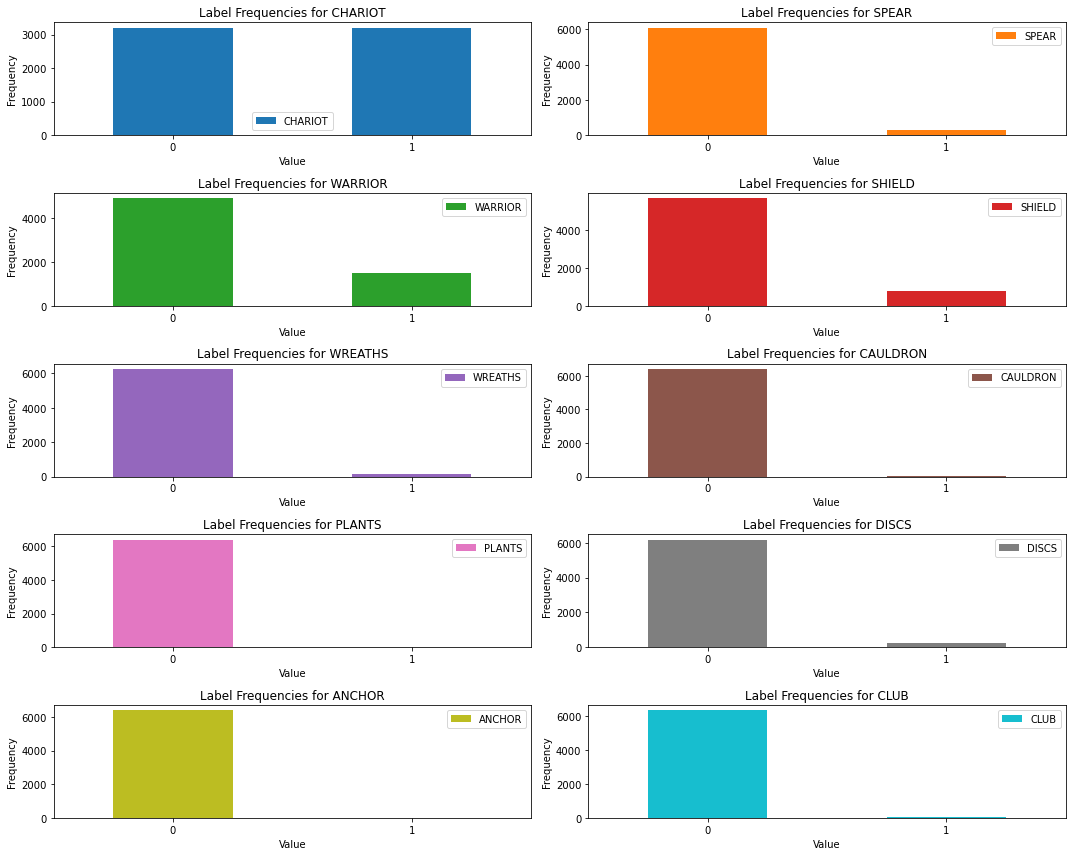

In [21]:
plot_classes(balanced_count_df)

**FINDINGS:**

Now, we see that the number of training examples with chariot label 0 and chariot label 1 are equal to each other. However, as mentioned above, this balancing distorted the distribution of the labels for other categories. In fact, we see that some of the categories are now majority label 1 instead of label 0. This may have to do with the fact that some pots that have one item (e.g. chariot) will also have a lot of the other items (e.g. warrior).

For this reason, this experiment is just a proof of concept to see whether data balancing helps the model improve at all. Specifically, we will focus on the model's performance on identifying chariots. 


### Downsampling Model

Now that we have our downsampled dataset, we will train a model with the same architecture as before for comparison. 

In [22]:
# function for calculating the loss
def generate_loss(n_output, loss):
    loss_dict = dict()
    for i in range(n_output):
        k = 'y'+str(i)
        loss_dict[k] = loss
    return loss_dict

# function for generating our desired architecture
# making this a function makes it far easier to generate
# empirical parameter counts, and to reuse the model architecture
# but with different parameters for both Part 1 and Part 2

def vgg_architecture(input_shape, n_output, conv_0_filters, dense_units,
                     conv_dropout=0.25, dense_dropout=0.5,
                     filter_shape=(3,3), pool_size=(2,2),
                     output_activation="softmax"):
    """generate simplified vgg-like sequential convolutional model
    
    This function can be used for building either a vgg-like
    classification model for PART 1 or regression model for PART 2
    depending on what is specified for the n_output and 
    output_activation parameters
    """
    n = conv_0_filters
    fs = filter_shape
    
    inputs = Input(shape=input_shape)
    x = Conv2D(
                n, fs, padding="same", activation="relu"
            )(inputs)
    x = Conv2D(n, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*2, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*2, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*4, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*4, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Flatten()(x)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dense_dropout)(x)
    
    y = Dense(10, activation="sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=y)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["binary_accuracy"])

    return model

In [23]:
conv_0_filters = 32
n_output=10

downsampled_vgg_model = vgg_architecture(
    input_shape=X_train[0].shape, n_output=n_output, conv_0_filters=conv_0_filters, 
    dense_units=1000, output_activation="sigmoid")
downsampled_vgg_model.summary()

# print number of params in model I will be training
print(
    "\n\nThe VGG-like model we will be training "
    "has {} filters in the first convolutional layer and it contains "
    "a total of {:,} parameters.".format(
        conv_0_filters, downsampled_vgg_model.count_params()
    )
)

print("Input", downsampled_vgg_model.input_shape, "\nOutput", downsampled_vgg_model.output_shape)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        3692

In [24]:
%%time

# After training your model, set the use_saved_model variable
# to True, and this cell will simply reload your already saved
# model and training history
use_saved_model = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train model if use_saved_model=False, else load saved model
if use_saved_model:
    downsampled_vgg_model.load_weights("model/ds_vgg_model/vgg_model.ckpt")
    with open("model/ds_vgg_model_hist_dict.pickle", "rb") as filehandler:
        downsampled_history_vgg_dict = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_vgg = downsampled_vgg_model.fit(X_train_balanced, y_train_balanced,
                        epochs=100, validation_split=0.2,verbose=1, callbacks=[early_stopping])

    # extract history dict from model history object
    downsampled_history_vgg_dict = history_vgg.history
    
    # save fitted training history dict using pickle
    with open("model/ds_vgg_model_hist_dict.pickle", "wb") as filehandler:
        pickle.dump(downsampled_history_vgg_dict, filehandler)
    # save model weights for future use
    downsampled_vgg_model.save_weights("model/ds_vgg_model/vgg_model.ckpt")
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Model weights and training history successfully loaded from previously trained model.

CPU times: user 72 ms, sys: 42.6 ms, total: 115 ms
Wall time: 112 ms


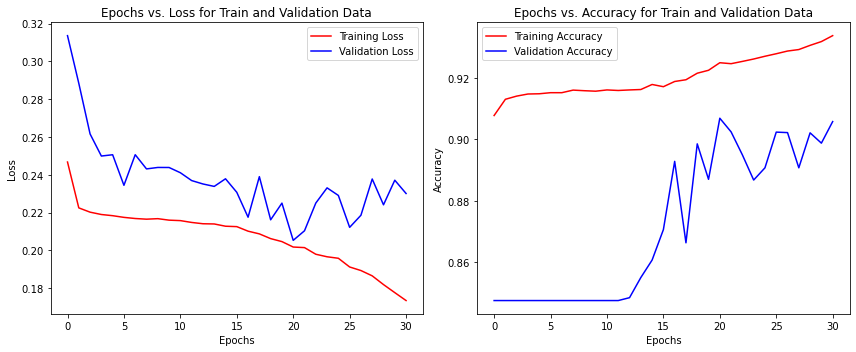

In [25]:
plot_acc_loss(downsampled_history_vgg_dict)

In [26]:
categories = ['Chariot', 'Spear', 'Warrior', 'Shield', 'Wreaths', 'Cauldron', 'Plant', 'Discs', 'Anchor', 'Club']
with pd.option_context('precision', 3):
    display(get_metrics(downsampled_vgg_model, X_test, y_test, categories))

Confusion Matrix for Chariot
[[7976 3096]
 [ 523  792]]
Confusion Matrix for Spear
[[11655     1]
 [  731     0]]
Confusion Matrix for Warrior
[[9837  451]
 [1940  159]]
Confusion Matrix for Shield
[[11154    23]
 [ 1203     7]]
Confusion Matrix for Wreaths
[[12039     0]
 [  348     0]]
Confusion Matrix for Cauldron
[[12383     0]
 [    4     0]]
Confusion Matrix for Plant
[[12319     0]
 [   68     0]]
Confusion Matrix for Discs
[[12061     0]
 [  326     0]]
Confusion Matrix for Anchor
[[12377     0]
 [   10     0]]
Confusion Matrix for Club
[[12223     0]
 [  164     0]]


/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedM

,class,accuracy,precision,recall,f1 score,naive accuracy,data positives,predicted positives
0,Chariot,0.708,0.204,0.602,0.304,0.894,1315,3888
1,Spear,0.941,0.000,0.000,0.000,0.941,731,1
2,Warrior,0.807,0.261,0.076,0.117,0.831,2099,610
3,Shield,0.901,0.233,0.006,0.011,0.902,1210,30
4,Wreaths,0.972,0.000,0.000,0.000,0.972,348,0
5,Cauldron,1.000,0.000,0.000,0.000,1.000,4,0
6,Plant,0.995,0.000,0.000,0.000,0.995,68,0
7,Discs,0.974,0.000,0.000,0.000,0.974,326,0
8,Anchor,0.999,0.000,0.000,0.000,0.999,10,0
9,Club,0.987,0.000,0.000,0.000,0.987,164,0


Focusing on the results for chariot (the attribute for which the class was balanced), we found that the number of predicted positives increased from 407 in the baseline to 3888 in this model (compared to the number of actual positives in the test set which was 1315). So, perhaps making the training set 50-50 0s and 1s for chariot actually overcompensated for the class imbalance and pushed the model toward predicting more 1s regardless of the input. We only see a slight increase in the f1 score (now 0.304 compared to baseline of 0.295), suggesting that the model did not actually improve in its ability to distinguish between images that do and do not contain chariots.

This downsampling model was simply an experiment to see if manipulating the distribution of the train dataset would improve the model’s performance. These results indicate that downsampling changes the model’s predictions but does not actually help it learn the features that distinguish an attribute like chariot. In addition, this is not a feasible approach for our task because it is difficult to balance all 10 attributes at once when each training sample has a 0/1 value for each of the 10 attributes. As such, we decided to explore another approach for addressing the class imbalance: data augmentation.



## VIII. Data Augmentation

**Viewing Tag Frequencies**

Below, we check the proportion of samples that contain each respective tag. For tags that appear relatively rarely, we may find it useful to perform data augmentation in order to prevent our model from defaulting to the naive model.

We found that if a tag was rare (occuring below ~0.1% of the time), the predictive model would often naively predict a negative for all samples, as this would result in a very high test accuracy. However, we seek to train a model that goes beyond this naive model in hope of potentially detecting these rare tags.

In [27]:
props = y_train.sum(axis=0)/len(y_train)

atts = ['CHARIOT', 'SPEAR', 'WARRIOR', 'SHIELD', 'WREATHS', 'CAULDRON', 'PLANTS', 'DISCS', 'ANCHOR', 'CLUB']
d = {'Tag Name': atts, 'Frequency': props}
tag_df = pd.DataFrame(data=d)
tag_df

,Tag Name,Frequency
0,CHARIOT,0.114269
1,SPEAR,0.052819
2,WARRIOR,0.160098
3,SHIELD,0.096366
4,WREATHS,0.022290
5,CAULDRON,0.000749
6,PLANTS,0.003531
7,DISCS,0.029245
8,ANCHOR,0.000856
9,CLUB,0.015728


### Data Augmentation Reasoning

Given the relative rareness of certain tags, we decided to implement data augmentation for some of the rarest tags, so that the model would have more positive examples to train on, in hopes of avoiding a naive prediction model. We selected the classes with the smallest frequency of occurance to be used for augmentation and inserted into the training dataset. In terms of image augmentation, we elected only to use translations, as we did not want to distort the shapes and proportions of the images, as these may affect how the images (and objects portrayed within them) appear, affecting the overall model.

The code has been commented out as the data augmentation was run only once, with the resulting dataset saved, to save time when running the notebook.

In [28]:
generate_aug = False

if generate_aug:
    indices = np.argwhere(y_test[:,5]>0).flatten().repeat(24)
    indices = np.concatenate((np.argwhere(y_test[:,6]>0).flatten().repeat(6), indices), axis=0)
    indices = np.concatenate((np.argwhere(y_test[:,8]>0).flatten().repeat(15), indices), axis=0)
    print(indices.shape)

    print(X_train.shape)
    X_train_new = np.zeros((indices.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]))
    print(X_train_new.shape)

    print(y_train.shape)
    y_train_new = np.zeros((indices.shape[0], y_train.shape[1]))
    print(y_train_new.shape)

    for i, index in enumerate(indices):
        transform = {}
        transform['theta'] = np.random.uniform(low=-5, high=5)
        transform['tx'] = np.random.uniform(low=-1, high=1)
        transform['ty'] = np.random.uniform(low=-1, high=1)
        image = X_train[index].reshape((X_train[index].shape[0],X_train[index].shape[1]))
        image = np.expand_dims(image, 2)
        transformed_data = np.array([tf.keras.preprocessing.image.ImageDataGenerator().apply_transform(image, transform)])
        transformed_data = transformed_data[0,:,:,0].reshape((1,X_train[index].shape[0], X_train[index].shape[1], 1))
        X_train_new[i,:,:,:] = transformed_data
        y_train_new[i,:] = y_train[index].reshape((1,10))

    X_train = np.concatenate((X_train, X_train_new))
    y_train = np.concatenate((y_train, y_train_new))
    print(X_train.shape)
    print(y_train.shape)


**Rerunning the Model for Augmented Dataset**

Below, we repeat the above procedure to train our model, this time on the augmented dataset to compare performance.

In [29]:
load_aug_data = False

if load_aug_data:
    y_train_temp = np.load('/content/drive/MyDrive/cs109b_final/data/y_train_aug.npy', allow_pickle=True)

    X_train_aug = np.load('/content/drive/MyDrive/cs109b_final/data/X_train_aug.npy')


    y_train_aug=y_train_temp
    y_test=np.array([np.array(y_test_temp[i][0]) for i in range(len(y_test_temp))])

    y_train0_aug = y_train_aug[:,0]
    y_train1_aug = y_train_aug[:,1]
    y_train2_aug = y_train_aug[:,2]
    y_train3_aug = y_train_aug[:,3]
    y_train4_aug = y_train_aug[:,4]
    y_train5_aug = y_train_aug[:,5]
    y_train6_aug = y_train_aug[:,6]
    y_train7_aug = y_train_aug[:,7]
    y_train8_aug = y_train_aug[:,8]
    y_train9_aug = y_train_aug[:,9]


In [30]:
if load_aug_data:
    print(f"X_train shape: {X_train_aug.shape}")
    print(f"y_train shape: {y_train_aug.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (12387, 128, 128, 1)
y_test shape: (12387, 10)


**Example of Augmented Image**

Text(0.5, 1.0, 'Augmented Image')

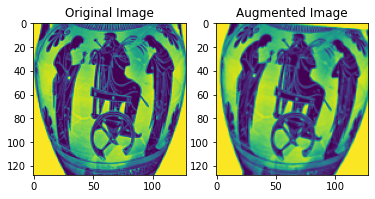

In [31]:
subset_aug_sample = np.load('orig_and_aug.npy')
fig, ax = plt.subplots(1,2, figsize=(6,6))
ax[0].imshow(subset_aug_sample[0])
ax[1].imshow(subset_aug_sample[1])
ax[0].set_title('Original Image')
ax[1].set_title('Augmented Image')

Above is an example of an original image and the corresponding augmentated image. We see that the two images are very similar, but the augmented version does seem more blurry.

In [32]:
# function for generating our desired architecture
# making this a function makes it far easier to generate
# empirical parameter counts, and to reuse the model architecture
# but with different parameters for both Part 1 and Part 2

def vgg_architecture(input_shape, n_output, conv_0_filters, dense_units,
                     conv_dropout=0.25, dense_dropout=0.5,
                     filter_shape=(3,3), pool_size=(2,2),
                     output_activation="softmax"):
    """generate simplified vgg-like sequential convolutional model
    
    This function can be used for building either a vgg-like
    classification model for PART 1 or regression model for PART 2
    depending on what is specified for the n_output and 
    output_activation parameters
    """
    n = conv_0_filters
    fs = filter_shape
    
    inputs = Input(shape=input_shape)
    x = Conv2D(
                n, fs, padding="same", activation="relu"
            )(inputs)
    x = Conv2D(n, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*2, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*2, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*4, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*4, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = Conv2D(n*8, fs, padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    x = Dropout(conv_dropout)(x)
    
    x = Flatten()(x)
    x = Dense(dense_units, activation="relu")(x)
    x = Dropout(dense_dropout)(x)
    
    y = Dense(n_output, activation="sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=y)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["binary_accuracy"])

    return model

In [33]:
conv_0_filters = 32
n_output=10

vgg_model_aug = vgg_architecture(
    input_shape=(128,128,1), n_output=n_output, conv_0_filters=conv_0_filters, 
    dense_units=1000, output_activation="sigmoid")
vgg_model_aug.summary()

# print number of params in model I will be training
print(
    "\n\nThe VGG-like model we will be training "
    "has {} filters in the first convolutional layer and it contains "
    "a total of {:,} parameters.".format(
        conv_0_filters, vgg_model_aug.count_params()
    )
)

print("Input", vgg_model_aug.input_shape, "\nOutput", vgg_model_aug.output_shape)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 64)        3692

In [34]:
%%time

# After training your model, set the use_saved_model variable
# to True, and this cell will simply reload your already saved
# model and training history
use_saved_model = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train model if use_saved_model=False, else load saved model
if use_saved_model:
    vgg_model_aug.load_weights("model/augmented/vgg_model_aug.ckpt")
    with open("model/vgg_model_aug_hist_dict.pickle", "rb") as filehandler:
        history_vgg_aug_dict = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history_vgg_aug = vgg_model_aug.fit(X_train_aug, y_train_aug,
                        epochs=100, validation_split=0.2,verbose=1, callbacks=[early_stopping])

    # extract history dict from model history object
    history_vgg_aug_dict = history_vgg_aug.history
    
    # mkdir for saving models if it doesn't already exist
    if not os.path.exists('/content/drive/MyDrive/cs109b_final/model'):
        os.mkdir('/content/drive/MyDrive/cs109b_final/model')
    # save fitted training history dict using pickle
    with open("/content/drive/MyDrive/cs109b_final/model/vgg_model_aug_hist_dict.pickle", "wb") as filehandler:
        pickle.dump(history_vgg_aug_dict, filehandler)
    # save model weights for future use
    vgg_model_aug.save_weights("/content/drive/MyDrive/cs109b_final/model/vgg_model_aug/vgg_model_aug.ckpt")
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )


Model weights and training history successfully loaded from previously trained model.

CPU times: user 90.3 ms, sys: 12.4 ms, total: 103 ms
Wall time: 100 ms


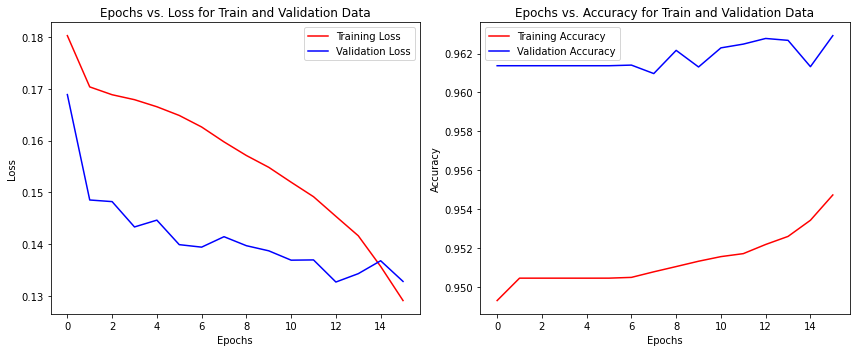

In [35]:
plot_acc_loss(history_vgg_aug_dict)

In [36]:
with pd.option_context('precision', 3):
    display(get_metrics(vgg_model_aug, X_test, y_test, ['Chariot', 'Spear', 'Warrior', 'Shield', 'Wreaths', 'Cauldron', 'Plant', 'Discs', 'Anchor', 'Club']))

Confusion Matrix for Chariot
[[10876   196]
 [  995   320]]
Confusion Matrix for Spear
[[11638    18]
 [  719    12]]
Confusion Matrix for Warrior
[[9992  296]
 [1931  168]]
Confusion Matrix for Shield
[[11109    68]
 [ 1185    25]]
Confusion Matrix for Wreaths
[[12039     0]
 [  348     0]]
Confusion Matrix for Cauldron
[[12383     0]
 [    4     0]]
Confusion Matrix for Plant
[[12319     0]
 [   68     0]]
Confusion Matrix for Discs
[[12060     1]
 [  326     0]]
Confusion Matrix for Anchor
[[12377     0]
 [   10     0]]
Confusion Matrix for Club
[[12223     0]
 [  164     0]]


/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedM

,class,accuracy,precision,recall,f1 score,naive accuracy,data positives,predicted positives
0,Chariot,0.904,0.620,0.243,0.350,0.894,1315,516
1,Spear,0.941,0.400,0.016,0.032,0.941,731,30
2,Warrior,0.820,0.362,0.080,0.131,0.831,2099,464
3,Shield,0.899,0.269,0.021,0.038,0.902,1210,93
4,Wreaths,0.972,0.000,0.000,0.000,0.972,348,0
5,Cauldron,1.000,0.000,0.000,0.000,1.000,4,0
6,Plant,0.995,0.000,0.000,0.000,0.995,68,0
7,Discs,0.974,0.000,0.000,0.000,0.974,326,1
8,Anchor,0.999,0.000,0.000,0.000,0.999,10,0
9,Club,0.987,0.000,0.000,0.000,0.987,164,0


**Data Augmentation vs. Baseline Model**

As we can see from the results above, the difference between the F1 scores from the model trained on augmented data versus the F1 scores from the model trained on the original data is not statistically significant. In addition, none of the rare tags have changed from F1 scores of 0 in the baseline model to nonzero F1 scores. This is likely because there are were so few positive examples to begin with, which makes it extremely difficult for the augmented data to produce any useful new examples for the model to train on.

Going forward, finding new, real examples of these rarer tags would likely be the most viable way of improving the performance of this model, as this would allow the model to learn to recognize the patterns of tags such as "cauldron" and "plant". In a sample that is overwhelmingly negative for these tags, especially given the noise in all the images, it is extremely difficult for a model to pick up on the patterns that distinguish "cauldron" and "plant" vases from other vases.

## IX. Transfer Learning

#### Motivation

Our dataset is of very limited size as most classes have under one thousand images. Additionally, the images are very complex and it is not easy differentiate between the classes. Transfer learning allows for the use of a model pre-trained on a much larger dataset. Theoretically by training this model on our dataset we can use some of the learned feature representations which will result in better performance. 

#### Implementation 

The transfer learning model we used is a combination of a pretrained feature extractor along with a single dense layer connected to the outputs. The feature extractor used is from MobileNetV2, a state of the art model trained on the ImageNet dataset which contains millions of images. Only the feature extraction head of the model is used, as the original MobileNet is not designed to output predictions on our classes. 

The transfer learning model takes a single color channel image and duplicates it three times to get a black and white three color channel image that can be fed into MobileNet. MobileNet then outputs 4x4x1280 features which are combined using average pooling to get 1280 features. A single dense layer with sigmoid activitaton then generates predicted probabilites for each of the classes. When training, the MobileNet feature extractor was frozen so only the final dense layer was trained. 

In order to achieve the best results on the test set, we decided to combine transfer learning with the augmented data as each had resulted in improved performance individually, in addition to training on the base dataset. 

Code and information was taken from the tensorflow transfer learning tutorial (https://www.tensorflow.org/tutorials/images/transfer_learning).

### Base Data

In [37]:
# preprocess images in tensor form for MobileNet
#  rescale inputs to [-1, 1]
#  duplicate single color
def preprocess(x):
    return tf.repeat(2 * x - 1, 3, axis=3)

# get a model ready for training
#  with the feature extraction from MobileNet
#  code from tensorflow transfer learning tutorial (https://www.tensorflow.org/tutorials/images/transfer_learning)
def get_model(img_size, num_classes):
    assert img_size in [96, 128, 160, 192, 224]
    
    # load the base model (MobileNetV2)
    img_shape = (img_size, img_size)
    base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape + (3,), include_top=False, weights='imagenet')
    base_model.trainable = False  # freeze the feature extractor

    # build a full model
    inputs = tf.keras.Input(img_shape + (1,))
    x = preprocess(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [38]:
# setup a transfer learning model
model_transfer = get_model(128, 10)
model_transfer.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['binary_accuracy'])
model_transfer.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
tf.math.multiply (TFOpLambda (None, 128, 128, 1)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 128, 128, 1)       0         
_________________________________________________________________
tf.repeat (TFOpLambda)       (None, 128, 128, None)    0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1281

In [39]:
# train the model
use_saved_model = True

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

if use_saved_model:
    model_transfer.load_weights("model/transfer_model.ckpt")
    with open("model/transfer_model_hist_dict.pickle", "rb") as filehandler:
        history_dict = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history = model_transfer.fit(X_train, y_train,
                        epochs=100, validation_split=0.2, verbose=1, callbacks=[early_stopping])

    # extract history dict from model history object
    history_dict = history.history
    
    # save fitted training history dict using pickle
    with open("model/transfer_model_hist_dict.pickle", "wb") as filehandler:
        pickle.dump(history_dict, filehandler)
    # save model weights for future use
    model_transfer.save_weights("model/transfer_model.ckpt")
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Model weights and training history successfully loaded from previously trained model.



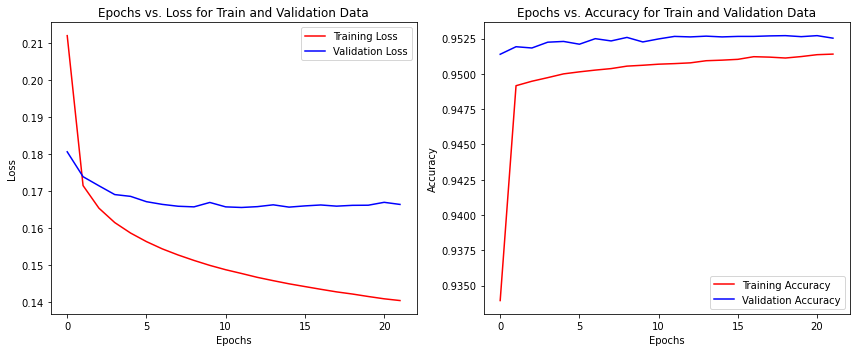

In [40]:
plot_acc_loss(history_dict)

In [41]:
# get metrics
with pd.option_context('precision', 3):
    display(get_metrics(model_transfer, X_test, y_test, ['Chariot', 'Spear', 'Warrior', 'Shield', 'Wreaths', 'Cauldron', 'Plant', 'Discs', 'Anchor', 'Club']))

Confusion Matrix for Chariot
[[10949   123]
 [ 1158   157]]
Confusion Matrix for Spear
[[11651     5]
 [  731     0]]
Confusion Matrix for Warrior
[[10204    84]
 [ 2039    60]]
Confusion Matrix for Shield
[[11170     7]
 [ 1200    10]]
Confusion Matrix for Wreaths
[[12038     1]
 [  348     0]]
Confusion Matrix for Cauldron
[[12383     0]
 [    4     0]]
Confusion Matrix for Plant
[[12319     0]
 [   68     0]]
Confusion Matrix for Discs
[[12059     2]
 [  323     3]]
Confusion Matrix for Anchor
[[12377     0]
 [   10     0]]
Confusion Matrix for Club
[[12223     0]
 [  164     0]]


/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedM

,class,accuracy,precision,recall,f1 score,naive accuracy,data positives,predicted positives
0,Chariot,0.897,0.561,0.119,0.197,0.894,1315,280
1,Spear,0.941,0.000,0.000,0.000,0.941,731,5
2,Warrior,0.829,0.417,0.029,0.053,0.831,2099,144
3,Shield,0.903,0.588,0.008,0.016,0.902,1210,17
4,Wreaths,0.972,0.000,0.000,0.000,0.972,348,1
5,Cauldron,1.000,0.000,0.000,0.000,1.000,4,0
6,Plant,0.995,0.000,0.000,0.000,0.995,68,0
7,Discs,0.974,0.600,0.009,0.018,0.974,326,5
8,Anchor,0.999,0.000,0.000,0.000,0.999,10,0
9,Club,0.987,0.000,0.000,0.000,0.987,164,0


###  Transfer Learning With Augmented Data

In [42]:
# setup a transfer learning model
model_transfer_aug = get_model(128, 10)
model_transfer_aug.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['binary_accuracy'])
model_transfer_aug.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
tf.math.multiply_1 (TFOpLamb (None, 128, 128, 1)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 128, 128, 1)       0         
_________________________________________________________________
tf.repeat_1 (TFOpLambda)     (None, 128, 128, None)    0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1281

In [43]:
# train the model
use_saved_model = True

if use_saved_model:
    model_transfer_aug.load_weights("model/transfer_model_aug.ckpt")
    with open("model/transfer_model_aug_hist_dict.pickle", "rb") as filehandler:
        history_dict = pickle.load(filehandler)
    print(
        "Model weights and training history successfully loaded"
        " from previously trained model.\n"
    )

else:
    # train the model
    history = model_transfer_aug.fit(X_train_aug, y_train_aug,
                        epochs=100, validation_split=0.2, verbose=1, callbacks=[early_stopping])

    # extract history dict from model history object
    history_dict = history.history
    
    # save fitted training history dict using pickle
    with open("model/transfer_model_aug_hist_dict.pickle", "wb") as filehandler:
        pickle.dump(history_dict, filehandler)
    # save model weights for future use
    model_transfer_aug.save_weights("model/transfer_model_aug.ckpt")
    print(
        "\n...model weights and training history successfully "
        "saved to file.\n"
    )

Model weights and training history successfully loaded from previously trained model.



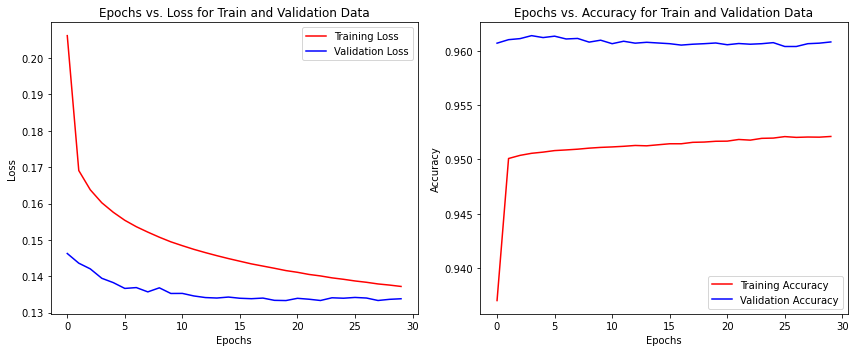

In [44]:
# plot loss
# plt.plot(history_dict['loss'], 'r', label='Training Loss')
# plt.plot(history_dict['val_loss'], 'b', label='Validation Loss')
# plt.legend()
# plt.title('Augmented Data Transfer Learning Model')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')

plot_acc_loss(history_dict)

In [45]:
# get metrics
with pd.option_context('precision', 3):
    display(get_metrics(model_transfer_aug, X_test, y_test, ['Chariot', 'Spear', 'Warrior', 'Shield', 'Wreaths', 'Cauldron', 'Plant', 'Discs', 'Anchor', 'Club']))

Confusion Matrix for Chariot
[[10939   133]
 [ 1148   167]]
Confusion Matrix for Spear
[[11644    12]
 [  730     1]]
Confusion Matrix for Warrior
[[10234    54]
 [ 2069    30]]
Confusion Matrix for Shield
[[11155    22]
 [ 1199    11]]
Confusion Matrix for Wreaths
[[12039     0]
 [  348     0]]
Confusion Matrix for Cauldron
[[12383     0]
 [    4     0]]
Confusion Matrix for Plant
[[12319     0]
 [   68     0]]
Confusion Matrix for Discs
[[12056     5]
 [  323     3]]
Confusion Matrix for Anchor
[[12377     0]
 [   10     0]]
Confusion Matrix for Club
[[12222     1]
 [  164     0]]


/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/share/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedM

,class,accuracy,precision,recall,f1 score,naive accuracy,data positives,predicted positives
0,Chariot,0.897,0.557,0.127,0.207,0.894,1315,300
1,Spear,0.940,0.077,0.001,0.003,0.941,731,13
2,Warrior,0.829,0.357,0.014,0.027,0.831,2099,84
3,Shield,0.901,0.333,0.009,0.018,0.902,1210,33
4,Wreaths,0.972,0.000,0.000,0.000,0.972,348,0
5,Cauldron,1.000,0.000,0.000,0.000,1.000,4,0
6,Plant,0.995,0.000,0.000,0.000,0.995,68,0
7,Discs,0.974,0.375,0.009,0.018,0.974,326,8
8,Anchor,0.999,0.000,0.000,0.000,0.999,10,0
9,Club,0.987,0.000,0.000,0.000,0.987,164,1


**Findings** 

The accuracy and f1 scores for the transfer learning model are very similar to those of the base model for both the base dataset and the augmented version. 

One potential limitation of transfer learning in this case is that the model was originally trained on full color images depicting objects in the real world, rather than black and white 2 dimensional drawings. Despite this, we would still expect the feature extraction layer to be able to capture some useful information about the images. 

While there is more we could try with this model, including fine-tuning the feature extraction head or regularization of the dense layer, the fact that this model and the base model both perform comparably to a naive model that always predicts 0 indicates that there are larger problems than model architecture impacting the performance. 

## X.Visualization

In order to better visualize the inaccurices of the models, we generated saliency maps for correctly and incorrectly predicted images. For each model and class, saliency maps for randomly drawn true positive, false positive, true negative, and false negative examples are shown. The saliency maps are for the true class of the image, so the maps should show the parts of the image that the model thinks are representative of the true class.

Visualizations for class "Chariot" with Baseline Model


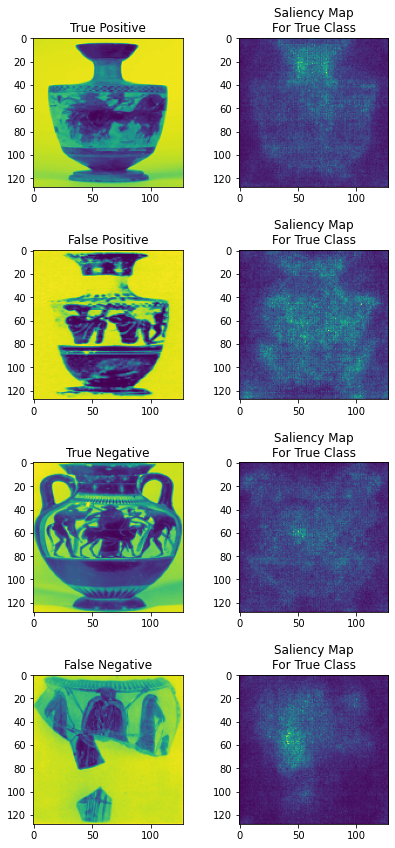

In [46]:
print('Visualizations for class "Chariot" with Baseline Model')
vizualize(vgg_model, X_test, y_test, 0)

Visualizations for class "Chariot" with Downsampling Model


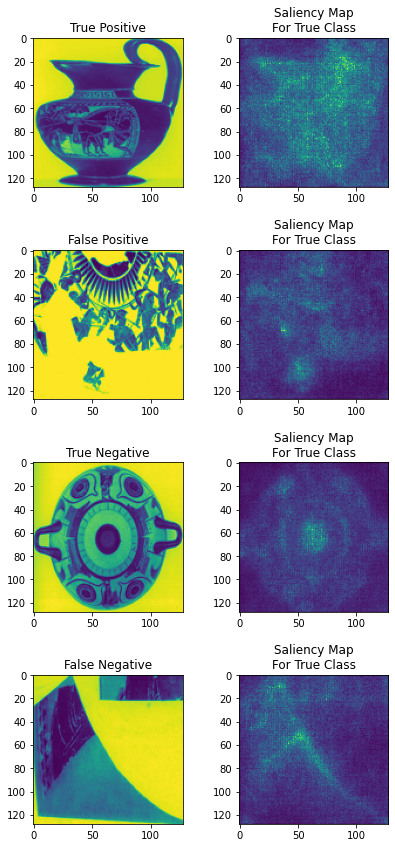

In [47]:
print('Visualizations for class "Chariot" with Downsampling Model')
vizualize(downsampled_vgg_model, X_test, y_test, 0)

Visualizations for class "Chariot" with Augmentation Model


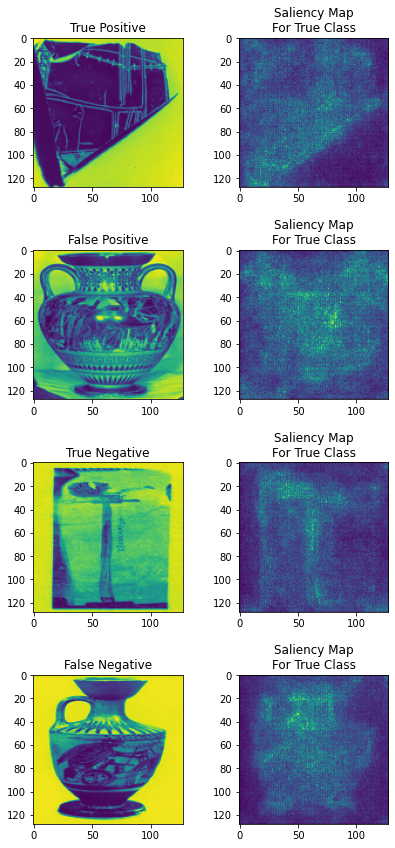

In [48]:
print('Visualizations for class "Chariot" with Augmentation Model')
vizualize(vgg_model_aug, X_test, y_test, 0)

Visualizations for class "Chariot" with Base Transfer Learning Model


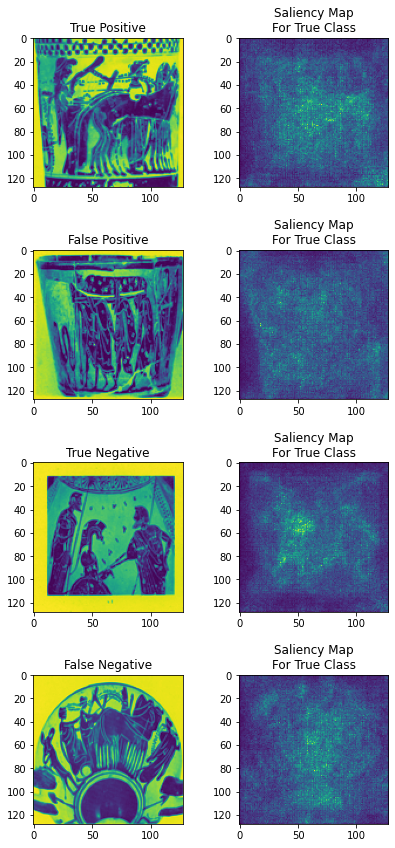

In [49]:
print('Visualizations for class "Chariot" with Base Transfer Learning Model')
vizualize(model_transfer, X_test, y_test, 0)

Visualizations for class "Chariot" with Augmented Data Transfer Learning Model


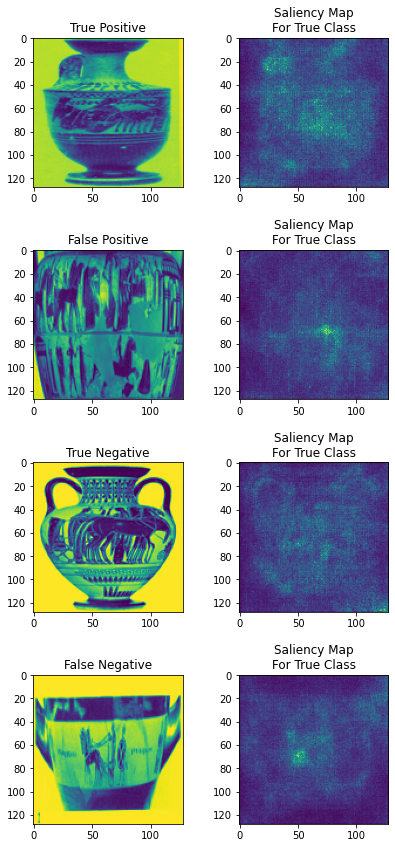

In [50]:
print('Visualizations for class "Chariot" with Augmented Data Transfer Learning Model')
vizualize(model_transfer_aug, X_test, y_test, 0)

**Findings**

When comparing the saliency maps from the transfer learning model to the maps from the base model there do not appear to be significant differences in the models. The same goes for comparing the maps of the models trained with the base dataset to those trained with the augmented data. Across all of the plots the model seems to have a difficult time focusing on the parts of the vase relevant to the class which is in this case chariot. We do, however, see that the models all generally focus on the vase itself rather than the background which indicates that the models did learn something and are not just making predictions at random or without regard for the input image. 


## XI. Limitations

Working with images meant that our datasets were large and computationally expensive to work with. Several trade-offs had to be made in the completion of this project, including the number of images we decided to work with, the resolution of these images, and the types of models we could experiment with. 

One of the recurring problems in our model stemmed from the fact that there were very few examples of certain attributes present in the dataset overall. This meant that it was difficult for the model to learn the distinguishing characteristics of these attributes.

In addition to the class imbalance, there was also significant variability in the images (in terms of the angle from which they were taken, the size of the vase, the original image size, etc.). These differences could have confused the model as it was training.
 
Also, because the scenes are so detailed, we found it difficult to identify these objects just with the human eye, and the differences between some of the attributes are very small. So, it’s unsurprising that the model also found this task difficult.

In training our models, we were also limited by compute power and memory, so we were only able to use images of 128x128 resolution. We already saw a significant jump in performance after increasing the resolution from 32x32 to 128x128, so if we had the time and resources, we would further increase the resolution to give the model more information to train on.

## XII. Conclusions

The aim of our project was to help automate the labelling process of images of Greek pottery, using already existing images in the database and their corresponding labels. Despite the limitations of our model, we were able to come out of this project with positive outcomes that pave the way towards making progress in this problem. By working with 128x128 images instead of 32x32 images, we found that higher resolutions were able to significantly improve the performance of our model, as the model was able to pick up on the finer details of images that would distinguish between labels, potentially better than the human eye.

Starting with a VGG16 model, we evaluated our results and iterated upon our model to find a technique that would improve the predictive performance of our model. To alleviate the imbalance between positive and negative labels between classes, we tried augmenting the dataset to increase the number of positive labels as well as downsampling to decrease the number of negative labels. Though the results were marginal, they show promise for creating a strong-performing model with a larger dataset that would include more examples of positive labels.

Given that feature extraction was heavily relevant to our task at-hand, we also applied transfer learning to the dataset. All of these techniques allowed us to explore the different ways to automate the task of automating vase labeling. Though our project has shown this to be a difficult task, our results also illuminate some promising approaches to tackle this problem in the future.


## XIII. Next Steps

By applying this modern-day problem in Greek pottery research to state of the art models, as well as exploring data augmentation and transfer learning techniques, we were able to explore the foundations of how data science can be applied to make meaningful progress in Greek pottery research. 

As limitations of the dataset was one of our biggest issues, finding more high quality data should be one of the highest priorities for future research. With more data and computational power, we could train stronger models while using higher resolution data in larger quantities. With more labeled data we could train models for finding the location of objects in the images in addition to just their presence in the images. 

While extensive manual work collecting and labeling data would be required, the benefits of better data may outweigh this effort. If researchers could easily search for examples of specific objects in the dataset they could better do their jobs. Additionally, next steps of research could go a different direction by looking at other facets of the dataset, such as extracting useful and consistent labels from the descriptions using NLP, or using some of the other metadata that comes along with the images. 

This sets the groundwork for making meaningful contributions to the field, as well as other fields of current-day research that involve the detection of specific objects and attributes in images. 
